In [10]:
# Imports
import audio_processing as ap
from sklearn.preprocessing import normalize
import numpy as np
from network import ContinuousHopfieldNetwork
import matplotlib.pyplot as plt
from tqdm import tqdm

In [2]:
# Generate sine waves (and save as wav files)

# Dictionary with all the frequencies and their associatd piano pitches
piano_frequencies = {
    55.00: 'A1', 58.27: 'A#1/Bb1',
    61.74: 'B1', 
    65.41: 'C2', 69.30: 'C#2/Db2',
    73.42: 'D2', 77.78: 'D#2/Eb2',
    82.41: 'E2', 87.31: 'F2', 92.50: 'F#2/Gb2',
    98.00: 'G2', 103.83: 'G#2/Ab2',
    110.00: 'A2', 116.54: 'A#2/Bb2',
    123.47: 'B2',
    130.81: 'C3', 138.59: 'C#3/Db3',
    146.83: 'D3', 155.56: 'D#3/Eb3',
    164.81: 'E3', 174.61: 'F3', 185.00: 'F#3/Gb3',
    196.00: 'G3', 207.65: 'G#3/Ab3',
    220.00: 'A3', 233.08: 'A#3/Bb3',
    246.94: 'B3',
    261.63: 'C4', 277.18: 'C#4/Db4',
    293.66: 'D4', 311.13: 'D#4/Eb4',
    329.63: 'E4', 349.23: 'F4', 369.99: 'F#4/Gb4',
    392.00: 'G4', 415.30: 'G#4/Ab4',
    440.00: 'A4', 466.16: 'A#4/Bb4',
    493.88: 'B4',
    523.25: 'C5', 554.37: 'C#5/Db5',
    587.33: 'D5', 622.25: 'D#5/Eb5',
    659.25: 'E5', 698.46: 'F5', 739.99: 'F#5/Gb5',
    783.99: 'G5', 830.61: 'G#5/Ab5',
    880.00: 'A5', 932.33: 'A#5/Bb5',
    987.77: 'B5',
    1046.50: 'C6', 1108.73: 'C#6/Db6',
    1174.66: 'D6', 1244.51: 'D#6/Eb6',
    1318.51: 'E6', 1396.91: 'F6', 1479.98: 'F#6/Gb6',
    1567.98: 'G6', 1661.22: 'G#6/Ab6',
    1760.00: 'A6'
}

clean_folder_path = "./audio/original_sine_waves/"

for frequency in piano_frequencies:
    file_name = clean_folder_path + f"{frequency}.wav"
    ap.generate_sine_wave_file(file_name, frequency=frequency)

In [33]:
# Add noise to sine waves (and save as wav files)

noisy_folder_path = "./audio/noisy_sine_waves/"

for frequency in piano_frequencies:
    clean_file = clean_folder_path + f"{frequency}.wav"
    noisy_file = noisy_folder_path + f"{frequency}.wav"
    ap.add_noise_to_wav(clean_file, noisy_file, noise_level=100000)

In [34]:
# Preprocess into a train and test dataset

train_data = []
test_data = []

mel_bins = 3000 # Hyperparameter
bit_precision = 8 # Hyperparameter

for frequency in list(piano_frequencies.keys()): # Slice for reduced size
    clean_file = clean_folder_path + f"{frequency}.wav"
    noisy_file = noisy_folder_path + f"{frequency}.wav"

    # Get the mel spectrogram
    clean_mags, clean_freqs = ap.compute_mel_spectrogram(clean_file, num_mel_filters=mel_bins)
    noisy_mags, noisy_freqs = ap.compute_mel_spectrogram(noisy_file, num_mel_filters=mel_bins)

    # Find frequency where it's above the range... TODO: maybe delete this
    index = np.where(clean_freqs > 10000)[0][0]
    clean_mags = clean_mags[:index]
    clean_freqs = clean_freqs[:index]
    noisy_mags = noisy_mags[:index]
    noisy_freqs = noisy_freqs[:index]

    # Normalize the data (no need to binarize since using CHN)
    clean_norm = normalize(clean_mags.reshape(-1, 1), axis=0)
    noisy_norm = normalize(noisy_mags.reshape(-1, 1), axis=0)

    # No need to flatten since already flat with continuous implementation

    # Add to dataset
    train_data.append(np.array(clean_norm).squeeze())
    test_data.append(np.array(noisy_norm).squeeze())
    
# Convert to numpy
train_data = np.array(train_data)
test_data = np.array(test_data)

In [35]:
# Initialize and train Hopfield net on clean audio
model = ContinuousHopfieldNetwork()

model.train(train_data)

In [6]:
# No weights to plot since CHN

In [36]:
# Get predictions with the Hopfield net from the noisy audio
print(train_data.shape)
predictions = model.predict(test_data, beta=10)

(61, 2350)


100%|██████████| 61/61 [00:00<00:00, 4461.40it/s]


100%|██████████| 61/61 [00:00<00:00, 793.67it/s]


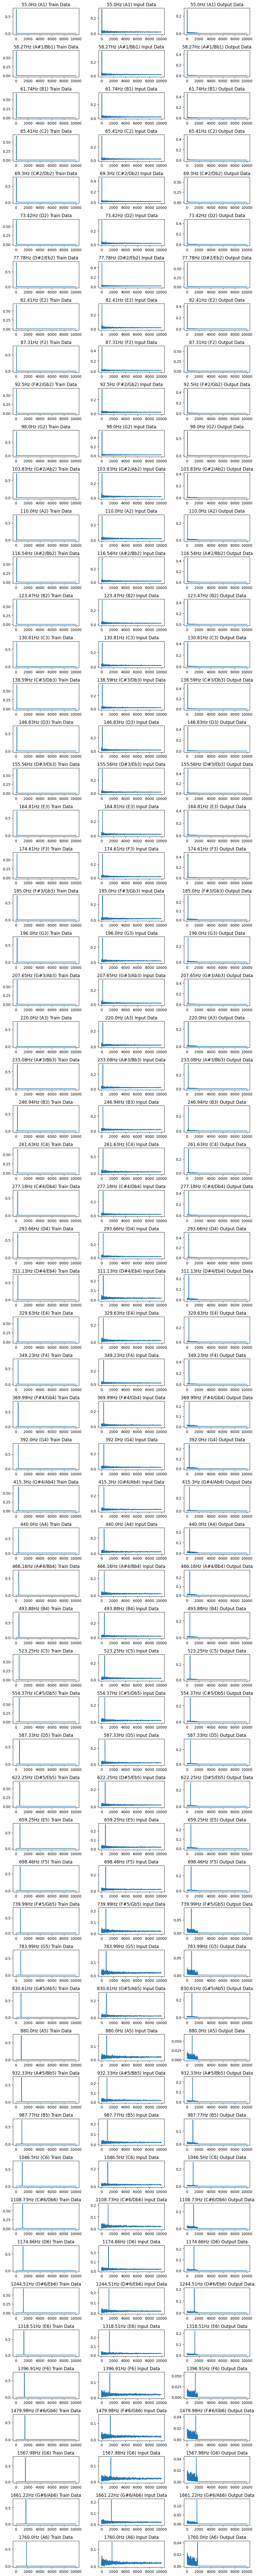

In [37]:
# Plot some example training vs predictions

figure, axes = plt.subplots(len(predictions), 3, figsize=(10,100))

freq_keys = list(piano_frequencies.keys())

c = 0
for i in tqdm(range(0, len(predictions))):
    original = train_data[i]
    noisy = test_data[i]
    cleaned = predictions[i]

    axes[c, 0].set_title(f"{freq_keys[i]}Hz ({piano_frequencies[freq_keys[i]]}) Train Data")
    axes[c, 1].set_title(f"{freq_keys[i]}Hz ({piano_frequencies[freq_keys[i]]}) Input Data")
    axes[c, 2].set_title(f"{freq_keys[i]}Hz ({piano_frequencies[freq_keys[i]]}) Output Data")

    axes[c, 0].plot(clean_freqs, original)
    axes[c, 1].plot(clean_freqs, noisy)
    axes[c, 2].plot(clean_freqs, cleaned)
    
    c += 1

plt.tight_layout()
plt.savefig("./figures/continuous_analysis/predictions.png")
plt.show()


In [27]:
# Find mean absolute prediction error
print(train_data.shape)
mae = np.mean(np.sum(np.abs(train_data-predictions), axis=1))
print(mae)

num = 40

pred_ind = np.where(predictions[num]==np.max(predictions[num]))
train_ind = np.where(train_data[num]==np.max(train_data[num]))

print(f"Max train mag of: {train_data[num][train_ind]} at {train_ind}")
print(f"Max pred mag of: {predictions[num][pred_ind]} at {pred_ind}")

print(f"Given freq: {clean_freqs[train_ind[0][0]]}")
print(f"Predicted freq: {clean_freqs[pred_ind[0][0]]}")

(61, 2350)
0.022860285856830195
Max train mag of: [0.6789788] at (array([502]),)
Max pred mag of: [0.67650539] at (array([502]),)
Given freq: 554.5928683075915
Predicted freq: 554.5928683075915


In [ ]:
# Make some plots showing how recovery accuracy changes with hyperparameters (noise level, threshold, num_iter, etc)

In [ ]:
# Make some plots showing how recovery accuracy changes with number of memories stored